In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.metrics import make_scorer,fbeta_score
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from sklearn.utils import resample

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

import importlib

# from eda_functions import data_exploration, draw_histogram, draw_countplot
import eda_functions as ef
importlib.reload(ef)
print()


In [2]:
SEED = 0

pd.set_option('display.max_colwidth', None, 
              'display.max_columns', None,
              'display.max_rows', None)


In [3]:

def get_scores(model, X_test, y_test):
    # Print the different scores
    y_pred = model.predict(X_test.values)   # add .values to avoir error and warnings
    print("   accuracy: ", round(accuracy_score(y_test, y_pred), 3))
    print("   AUC: ", round(roc_auc_score(y_test, y_pred), 3))
    print("   precision: ", round(precision_score(y_test,y_pred), 3))
    print("   recall: ", round(recall_score(y_test,y_pred), 3))
    print("   f1: ", round(f1_score(y_test, y_pred), 3))
    # print("   ", confusion_matrix(y_test, y_pred))
    f, ax = plt.subplots(figsize=(2, 2))
    cmap = sns.diverging_palette(180, 180, as_cmap=True)
    sns.heatmap(confusion_matrix(y_test, y_pred),  vmax=.9, center=0, fmt='.0f',  cmap=cmap, # mask=mask, 
                       square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True) #True)
    plt.show()

    
def fit_score_model(model, X_train, y_train, X_test, y_test, title):
    # Fit a model to the training data and print the scores
    model.fit(X_train.values, y_train)
    print('\n--- ' + title + ' Model ---')
    print('Scores on the train set:')
    get_scores(model, X_train, y_train)
    print('Scores on the test set:')
    get_scores(model, X_test, y_test)
    return model

def run_kfold(model, X_train, y_train, title):
    scores = []
    cv = KFold(n_splits=10, random_state=SEED, shuffle=True)   # tc params

    for train_index, valid_index in cv.split(X_train):
        # print("Index du train : ", train_index)
        # print("Index de validation : ", valid_index, "\n")
        X_train2, X_valid, y_train2, y_valid = (
            X_train.iloc[train_index], X_train.iloc[valid_index], 
            y_train.iloc[train_index], y_train.iloc[valid_index] )
        model.fit(X_train2.values, y_train2)
        y_pred = model.predict(X_valid.values)
        scores.append(round(f1_score(y_valid, y_pred), 3))
    print('--- ' + title + ' Model (F1 score) ---')
    print('   ', scores)
    print('   ', round(np.mean(scores),3), '+/-', round(np.std(scores),3), '\n')
    return model

def draw_histograms(data, logx=False, logy=False):
    # Check the distribution of the values (and potential outliers or errors)
    # fig, ax = plt.subplots(figsize=(2, 20))
    # data0.plot.hist(subplots=True, legend=False, layout=(32, 3), ax=ax)
    # plt.show()
    for col in data.columns: 
        fig, ax = plt.subplots(figsize=(15, 2))
        data[col].plot.hist(legend=True, bins=200, logx = logx, logy=logy)
        plt.show()
        

In [4]:
# Get the data

data0 = pd.read_csv('brfss2021_cleaned.csv')
data0.drop(['Unnamed: 0'], axis=1, inplace=True)
print(data0.shape)

(272753, 27)


In [5]:
categorical_columns = [
    'state_id', 'sex', 'general_health', 'med_cost_issue', 'physical_activity', 'blood_pressure',
    'cholesterol', 'stroke', 'asthma', 'depression', 'diabete', 'arthritis', 'education', 'veteran', 
    'income', 'smoked_100_cig', 'is_urban', 'race', 'age', 'bmi', 'cvd', 'cancer'
]
for col in categorical_columns:
    data0[col] = data0[col].astype('category')


In [6]:
# Correlations

# As most of the features are categorical, the 5 numericalfeatures are binned to become categorical
# so that the statistical method Cramer-V can be used to study the "correlations" between the features

data2 = data0.copy()
data2['fruits'] = pd.cut(x=data2['fruits'], bins=2*15) #bins=list(range(1, 16)))
data2['vegetables'] = pd.cut(x=data2['vegetables'], bins=2*20)
data2['alcohol'] = pd.cut(x=data2['alcohol'], bins=2*8)
data2['weight'] = pd.cut(x=data2['weight'], bins=35)
data2['height'] = pd.cut(x=data2['height'], bins=17)  #16
display(data2.head())


,state_id,sex,general_health,med_cost_issue,physical_activity,blood_pressure,cholesterol,stroke,asthma,depression,diabete,arthritis,education,veteran,income,weight,height,smoked_100_cig,is_urban,race,age,bmi,alcohol,fruits,vegetables,cvd,cancer
0,1,F,2.0,no,no,yes,no,no,no,no,yes,no,high-school,no,15-20k,"(74.999, 79.999]","(1.623, 1.669]",no,yes,black,72.0,overweight,"(-0.008, 0.5]","(0.5, 1.0]","(0.5, 1.0]",1,0
1,1,F,2.0,no,yes,yes,yes,no,no,no,yes,no,high-school,no,50-75k,"(84.999, 89.999]","(1.623, 1.669]",no,yes,white,62.0,obese,"(-0.008, 0.5]","(1.0, 1.5]","(1.5, 2.0]",0,0
2,1,M,3.0,no,no,no,no,no,no,no,no,no,some college,no,35-50k,"(84.999, 89.999]","(1.9, 1.946]",yes,no,white,82.0,normalweight,"(-0.008, 0.5]","(-0.015, 0.5]","(-0.02, 0.5]",0,0
3,1,M,3.0,no,no,yes,no,no,no,yes,no,yes,college,no,100-150k,"(149.998, 154.997]","(1.807, 1.853]",no,yes,white,62.0,obese,"(-0.008, 0.5]","(-0.015, 0.5]","(1.0, 1.5]",0,0
4,1,M,4.0,no,yes,yes,yes,no,no,no,no,yes,some high-school,no,<10k,"(65.0, 69.999]","(1.715, 1.761]",yes,yes,white,62.0,normalweight,"(-0.008, 0.5]","(0.5, 1.0]","(1.0, 1.5]",1,0


In [7]:
ef.data_exploration(data2)

,state_id,sex,general_health,med_cost_issue,physical_activity,blood_pressure,cholesterol,stroke,asthma,depression,diabete,arthritis,education,veteran,income,weight,height,smoked_100_cig,is_urban,race,age,bmi,alcohol,fruits,vegetables,cvd,cancer
0,1,F,2.0,no,no,yes,no,no,no,no,yes,no,high-school,no,15-20k,"(74.999, 79.999]","(1.623, 1.669]",no,yes,black,72.0,overweight,"(-0.008, 0.5]","(0.5, 1.0]","(0.5, 1.0]",1,0
1,1,F,2.0,no,yes,yes,yes,no,no,no,yes,no,high-school,no,50-75k,"(84.999, 89.999]","(1.623, 1.669]",no,yes,white,62.0,obese,"(-0.008, 0.5]","(1.0, 1.5]","(1.5, 2.0]",0,0
2,1,M,3.0,no,no,no,no,no,no,no,no,no,some college,no,35-50k,"(84.999, 89.999]","(1.9, 1.946]",yes,no,white,82.0,normalweight,"(-0.008, 0.5]","(-0.015, 0.5]","(-0.02, 0.5]",0,0
3,1,M,3.0,no,no,yes,no,no,no,yes,no,yes,college,no,100-150k,"(149.998, 154.997]","(1.807, 1.853]",no,yes,white,62.0,obese,"(-0.008, 0.5]","(-0.015, 0.5]","(1.0, 1.5]",0,0
4,1,M,4.0,no,yes,yes,yes,no,no,no,no,yes,some high-school,no,<10k,"(65.0, 69.999]","(1.715, 1.761]",yes,yes,white,62.0,normalweight,"(-0.008, 0.5]","(0.5, 1.0]","(1.0, 1.5]",1,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272753 entries, 0 to 272752
Data columns (total 27 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   state_id           272753 non-null  category
 1   sex                272753 non-null  category
 2   general_health     272753 non-null  category
 3   med_cost_issue     272753 non-null  category
 4   physical_activity  272753 non-null  category
 5   blood_pressure     272753 non-null  category
 6   cholesterol        272753 non-null  category
 7   stroke             272753 non-null  category
 8   asthma             272753 non-null  category
 9   depression         272753 non-null  category
 10  diabete            272753 non-null  category
 11  arthritis          272753 non-null  category
 12  education          272753 non-null  category
 13  veteran            272753 non-null  category
 14  income             272753 non-null  category
 15  weight             272753 non-nul

,count,unique,top,freq
state_id,272753,53,36,22239
sex,272753,2,F,145512
general_health,272753.0,5.0,2.0,97252.0
med_cost_issue,272753,2,no,255890
physical_activity,272753,2,yes,211210
blood_pressure,272753,2,no,152582
cholesterol,272753,2,no,162530
stroke,272753,2,no,261907
asthma,272753,2,no,234607
depression,272753,2,no,218224


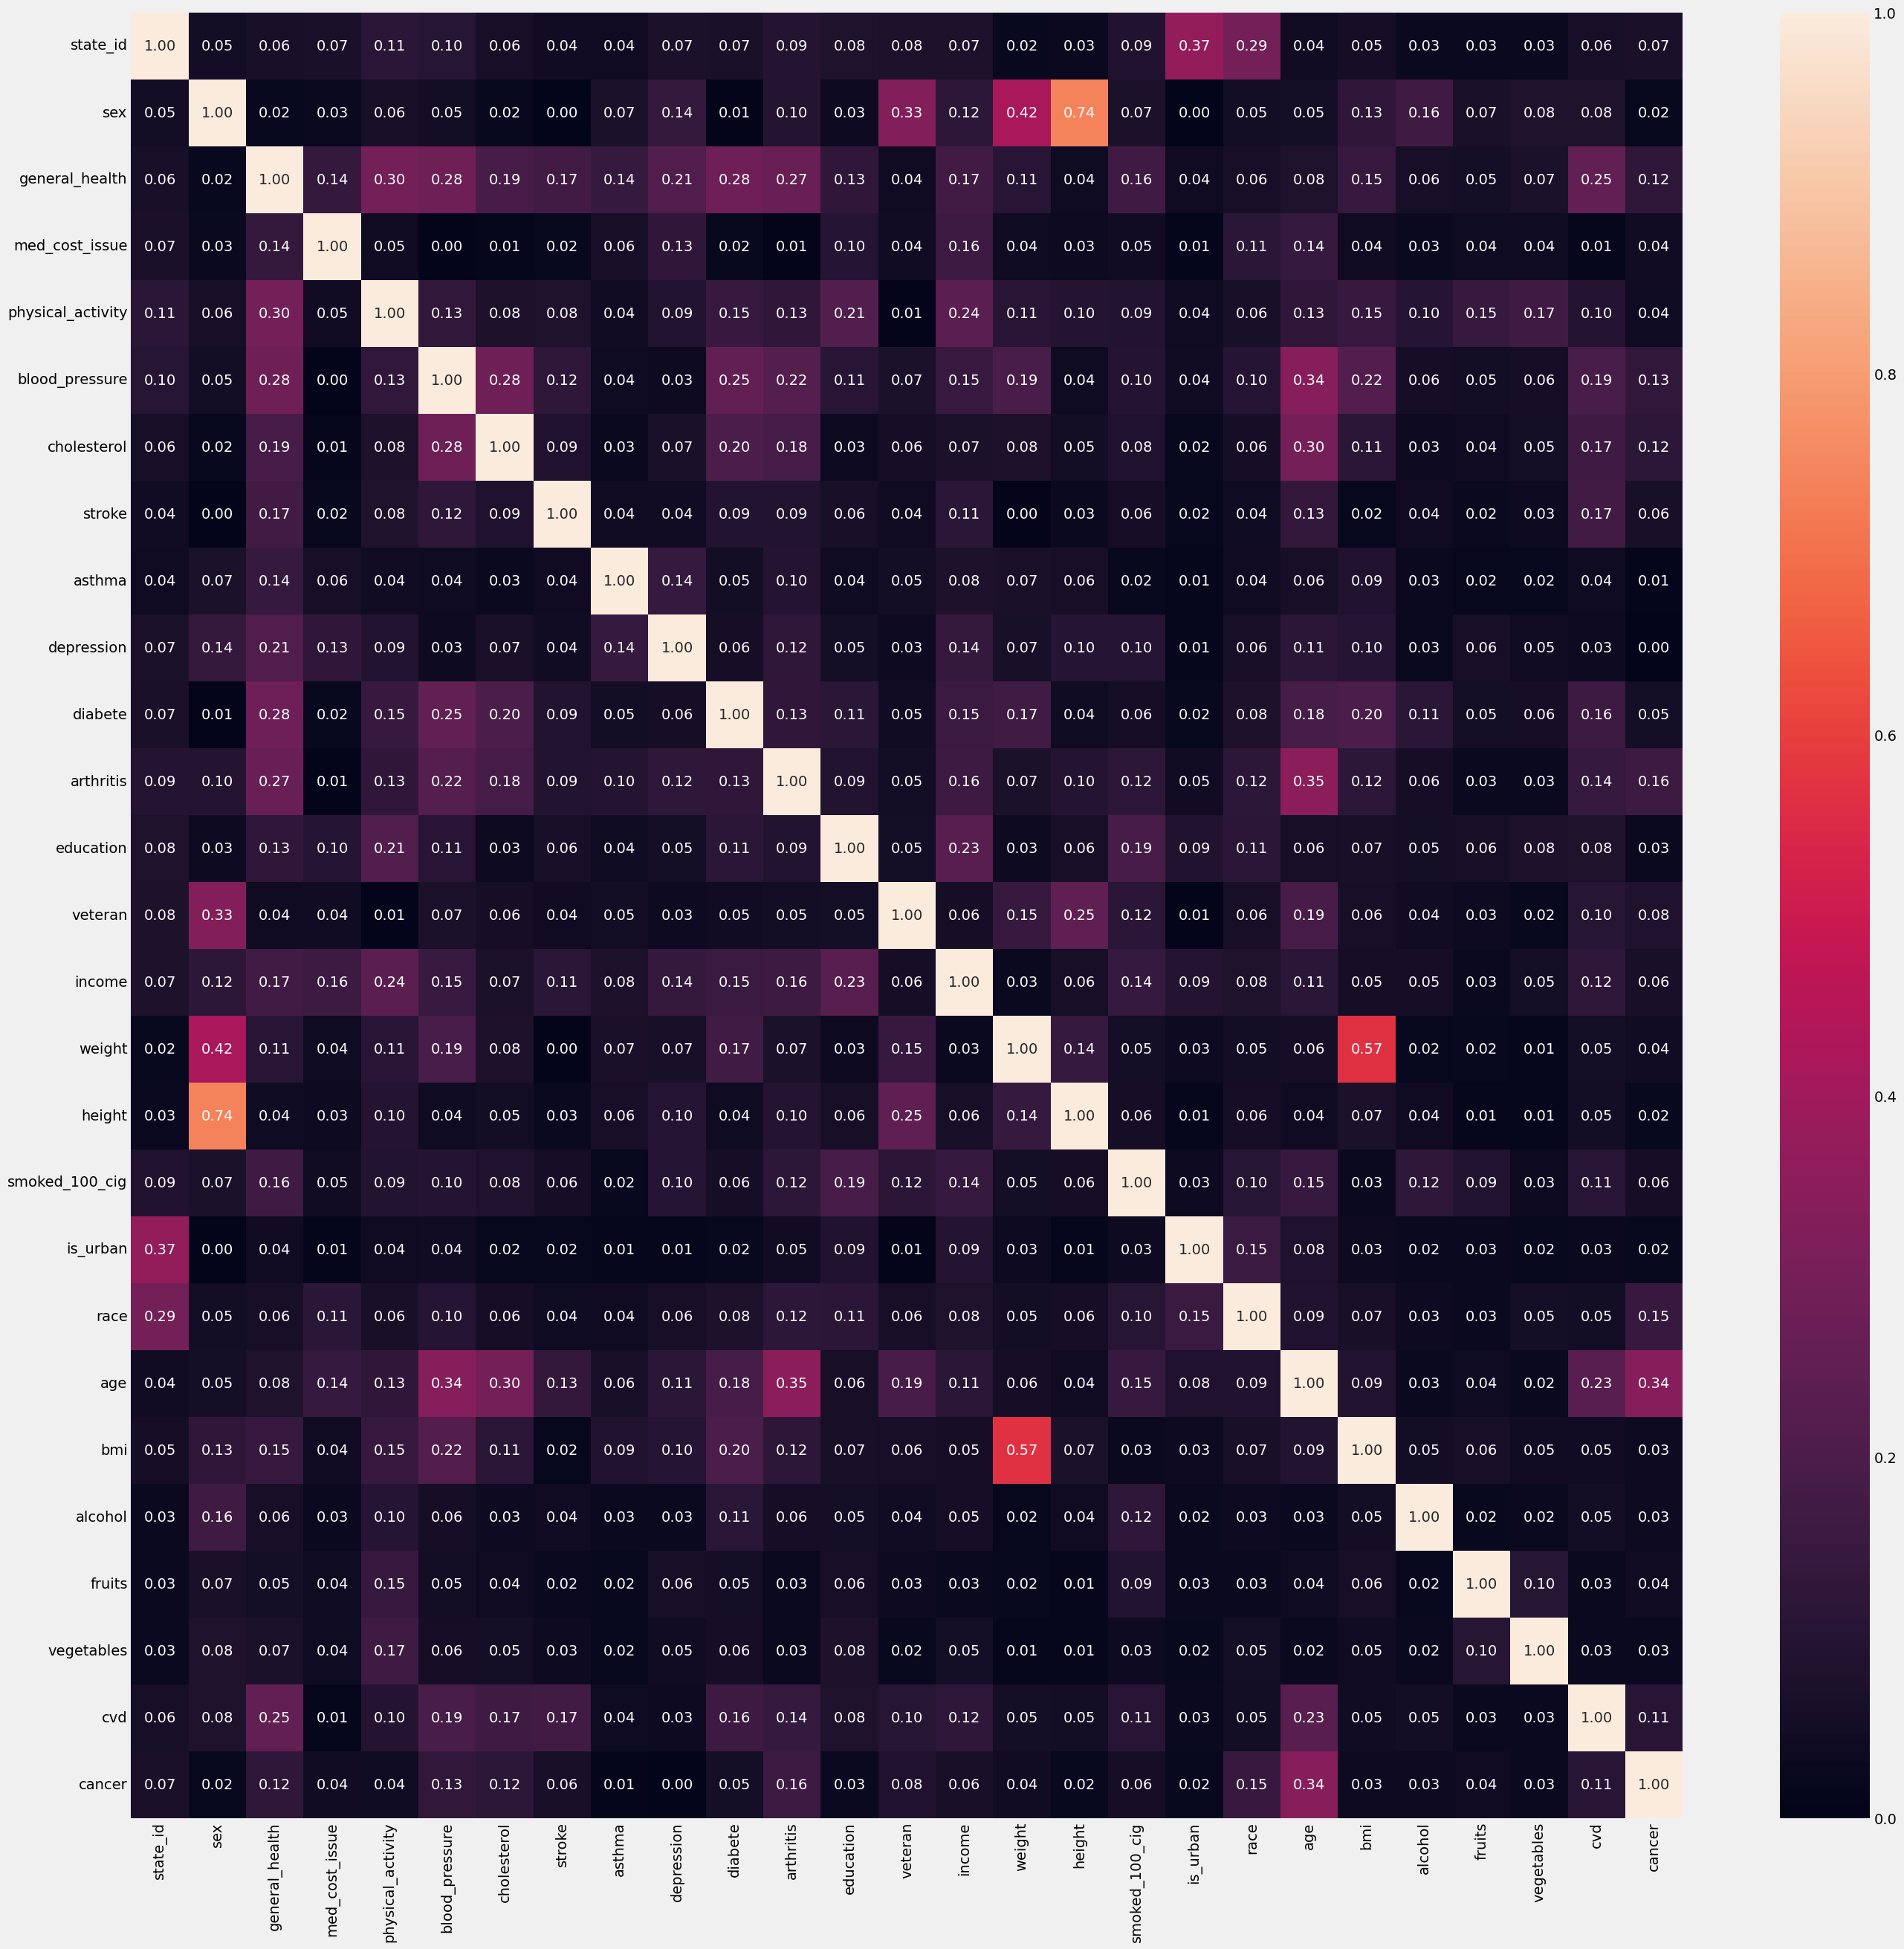

In [8]:
# Heatmap with the Cramer-V coefficients
# This cell is from stackoverflow

from itertools import combinations
from scipy.stats import chi2_contingency
import scipy.stats as ss
import seaborn as sns
def get_corr_mat(df, f=chi2_contingency):
        columns = df.columns
        dm = pd.DataFrame(index=columns, columns=columns)
        for var1, var2 in combinations(columns, 2):
            cont_table = pd.crosstab(df[var1], df[var2], margins=False)
            chi2_stat = cramers_v(cont_table.values)
            dm.loc[var2, var1] = chi2_stat
            dm.loc[var1, var2] = chi2_stat
        dm.fillna(1, inplace=True)
        return dm

def cramers_v(confusion_matrix):
        """ calculate Cramers V statistic for categorial-categorial association.
            uses correction from Bergsma and Wicher,
            Journal of the Korean Statistical Society 42 (2013): 323-328
        """
        chi2 = ss.chi2_contingency(confusion_matrix)[0]
        n = confusion_matrix.sum()
        phi2 = chi2 / n
        r, k = confusion_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

    
# cat_corr= get_corr_mat(data1[categorical_columns])
cat_corr = get_corr_mat(data2)
fig, ax = plt.subplots(figsize=(30,30))
cmap = sns.diverging_palette(180, 180, as_cmap=True)
sns.heatmap(cat_corr, annot = True, fmt='.2f')#, cmap=cmap)
plt.show()


In [14]:
# Removal of the features not correlated to the target (<0.08)
print(data0.columns)
display(cat_corr['cvd'].sort_values(ascending=False))

Index(['state_id', 'sex', 'general_health', 'med_cost_issue',
       'physical_activity', 'blood_pressure', 'cholesterol', 'stroke',
       'asthma', 'depression', 'diabete', 'arthritis', 'education', 'veteran',
       'income', 'weight', 'height', 'smoked_100_cig', 'is_urban', 'race',
       'age', 'bmi', 'alcohol', 'fruits', 'vegetables', 'cvd', 'cancer'],
      dtype='object')


cvd                  1.000000
general_health       0.251280
age                  0.226680
blood_pressure       0.192921
stroke               0.174843
cholesterol          0.166678
diabete              0.160697
arthritis            0.143261
income               0.121496
cancer               0.108220
smoked_100_cig       0.107786
veteran              0.104659
physical_activity    0.096007
sex                  0.080229
education            0.079620
state_id             0.060713
weight               0.051232
height               0.049656
race                 0.047914
alcohol              0.047473
bmi                  0.045860
asthma               0.038196
depression           0.034195
vegetables           0.031234
is_urban             0.030851
fruits               0.029355
med_cost_issue       0.011929
Name: cvd, dtype: float64

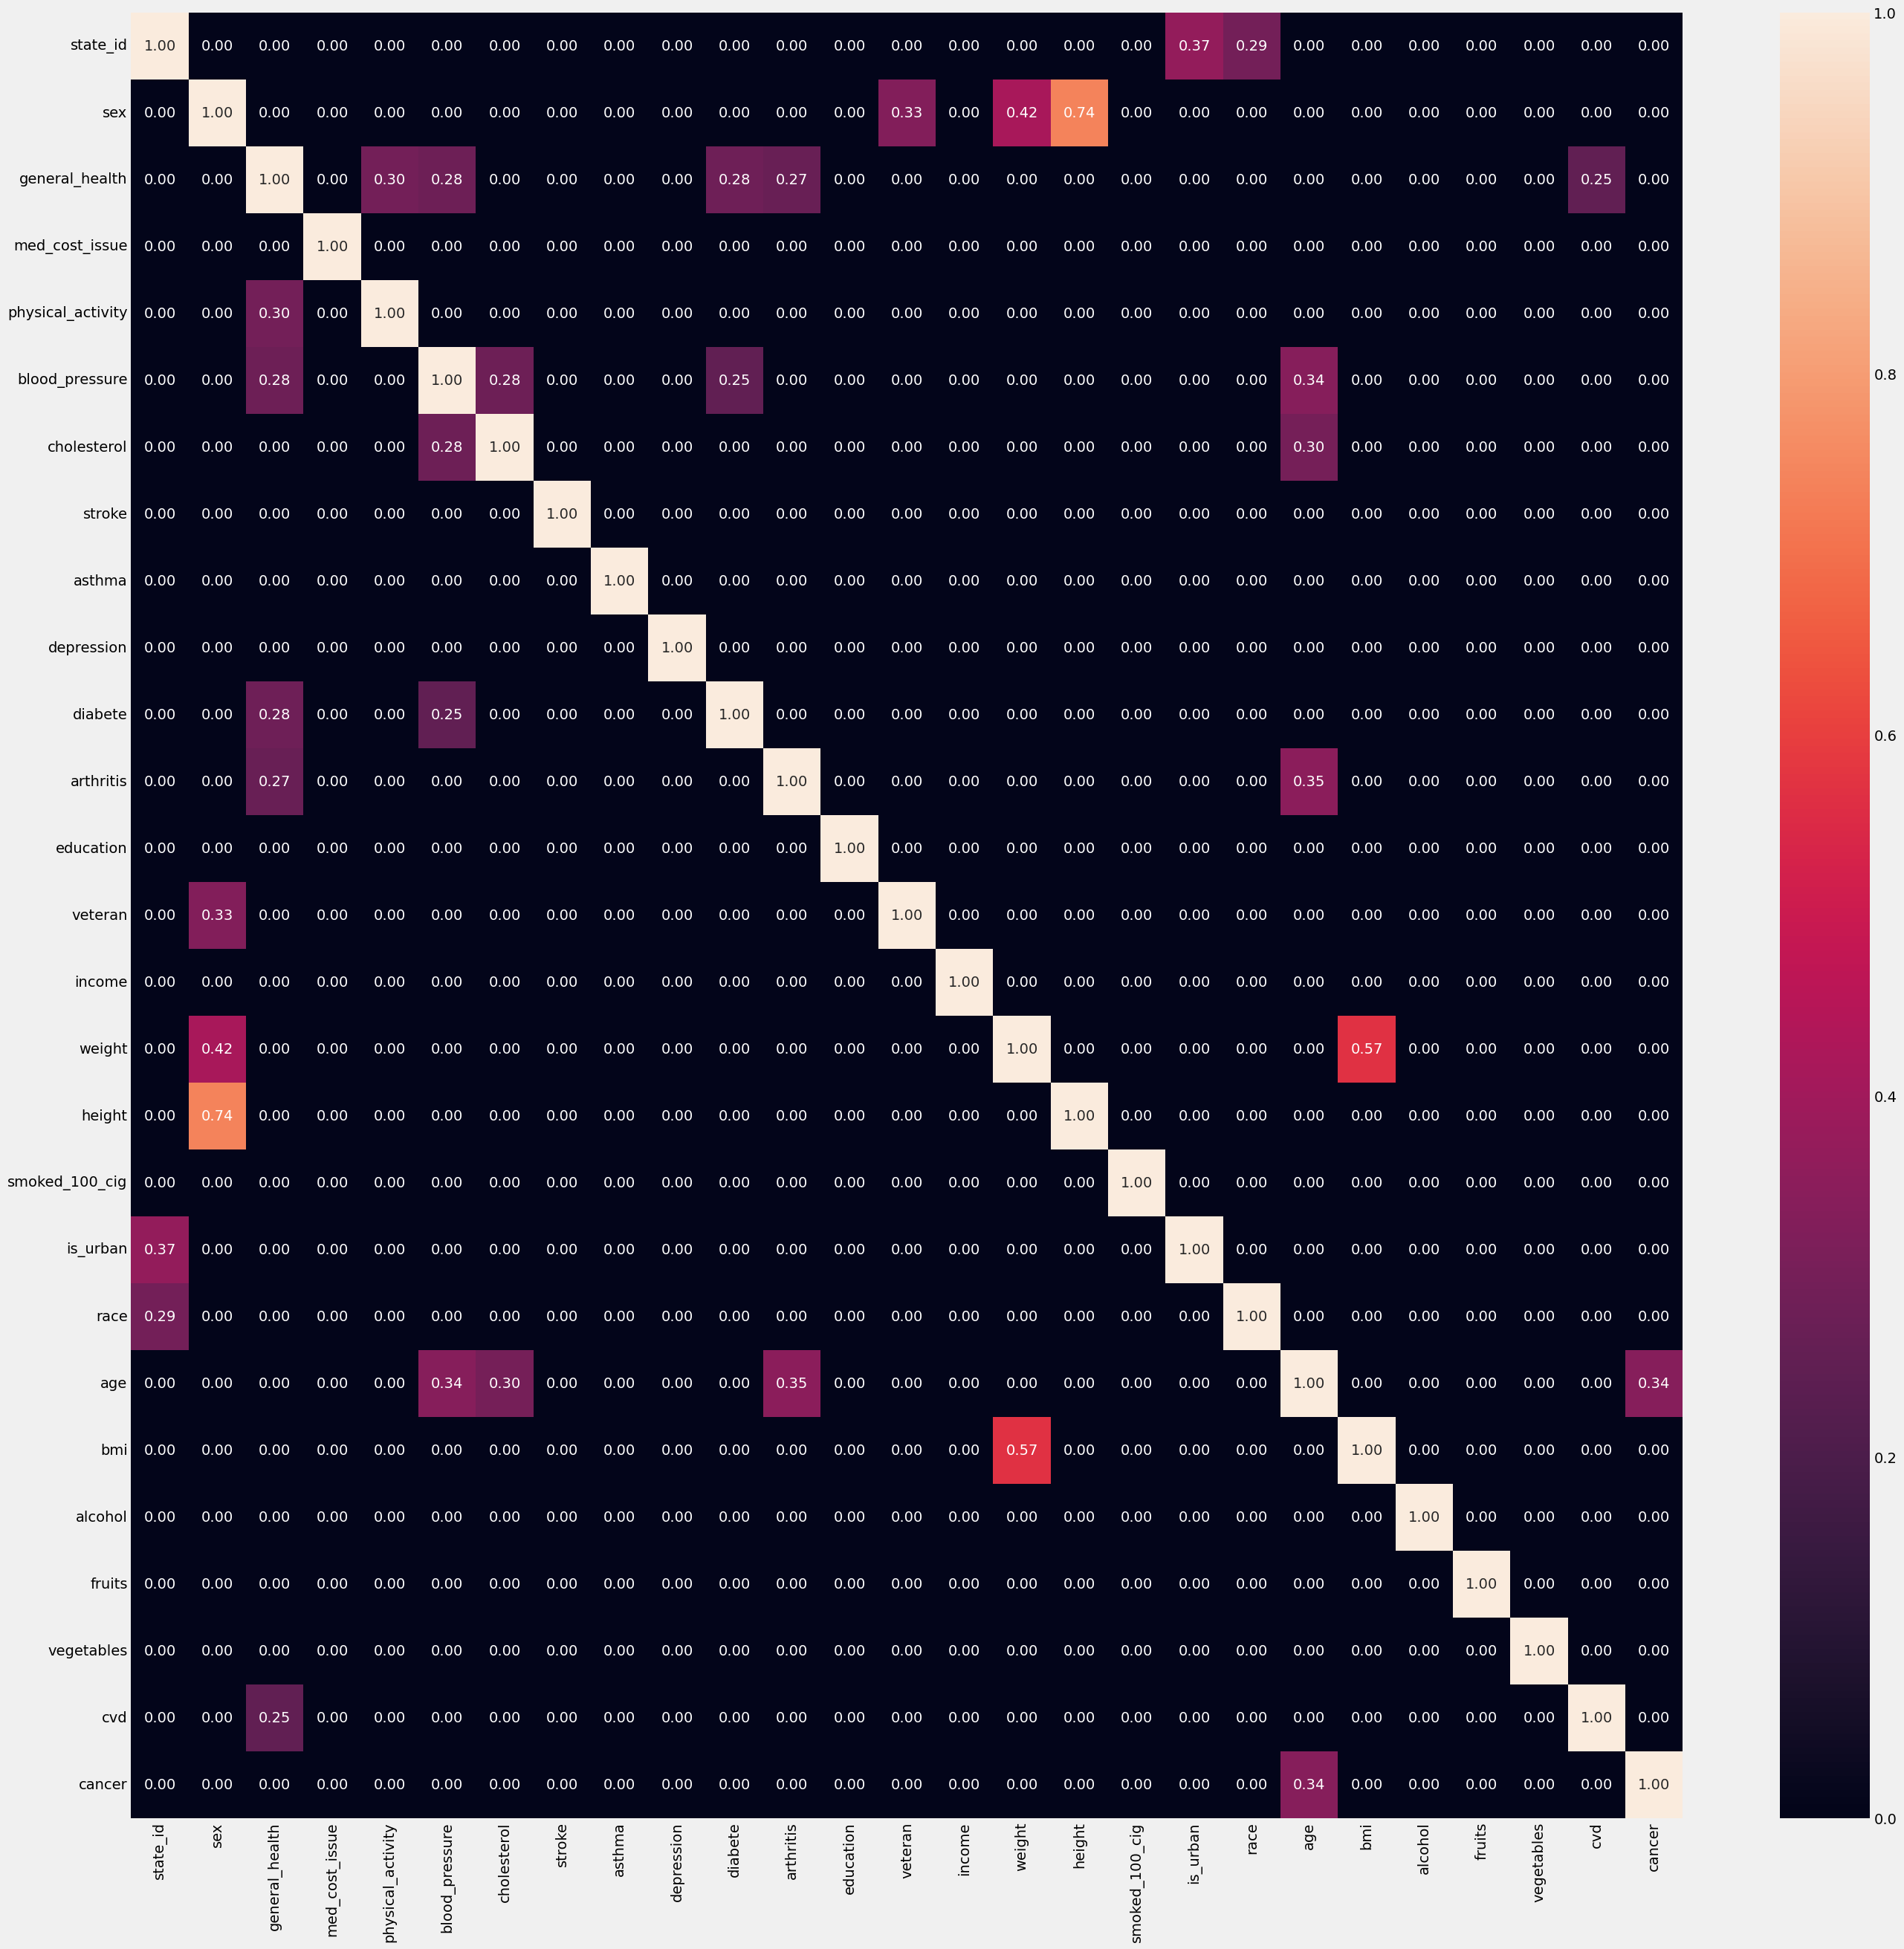

In [15]:
# Display the largest Cramer-V coefficients
fig, ax = plt.subplots(figsize=(30,30))
cmap = sns.diverging_palette(180, 180, as_cmap=True)
sns.heatmap(cat_corr[cat_corr > 0.25].iloc[:, :].fillna(0),
            annot = True, fmt='.2f') #, cmap=cmap)
plt.show()


In [10]:
chosen_cols = [   
       'physical_activity', 'blood_pressure', 'cholesterol', 'stroke',
       'diabete', 'arthritis', 'veteran', 'income', 'smoked_100_cig', 
       'age', 'cancer', 'cvd',
       'sex',
]
# chosen_cols = ['sex', 'is_urban', 'med_cost_issue', 'state_id', 
#        'physical_activity', 'blood_pressure', 'cholesterol', 'stroke',
#        'asthma', 'depression', 'diabete', 'arthritis', 'education', 'veteran',
#        'income', 'weight', 'height', 'smoked_100_cig',  'race',
#        'age', 'bmi', 'cvd', 'cancer', 'alcohol', 'fruits', 'vegetables', ]  
# 'general_health' -> target leaking

# chosen_cols = data0.columns

yesno_cols = [ 
       'physical_activity', 'blood_pressure', 'cholesterol', 'stroke',
       'diabete', 'arthritis', 'veteran', 'smoked_100_cig', 
]

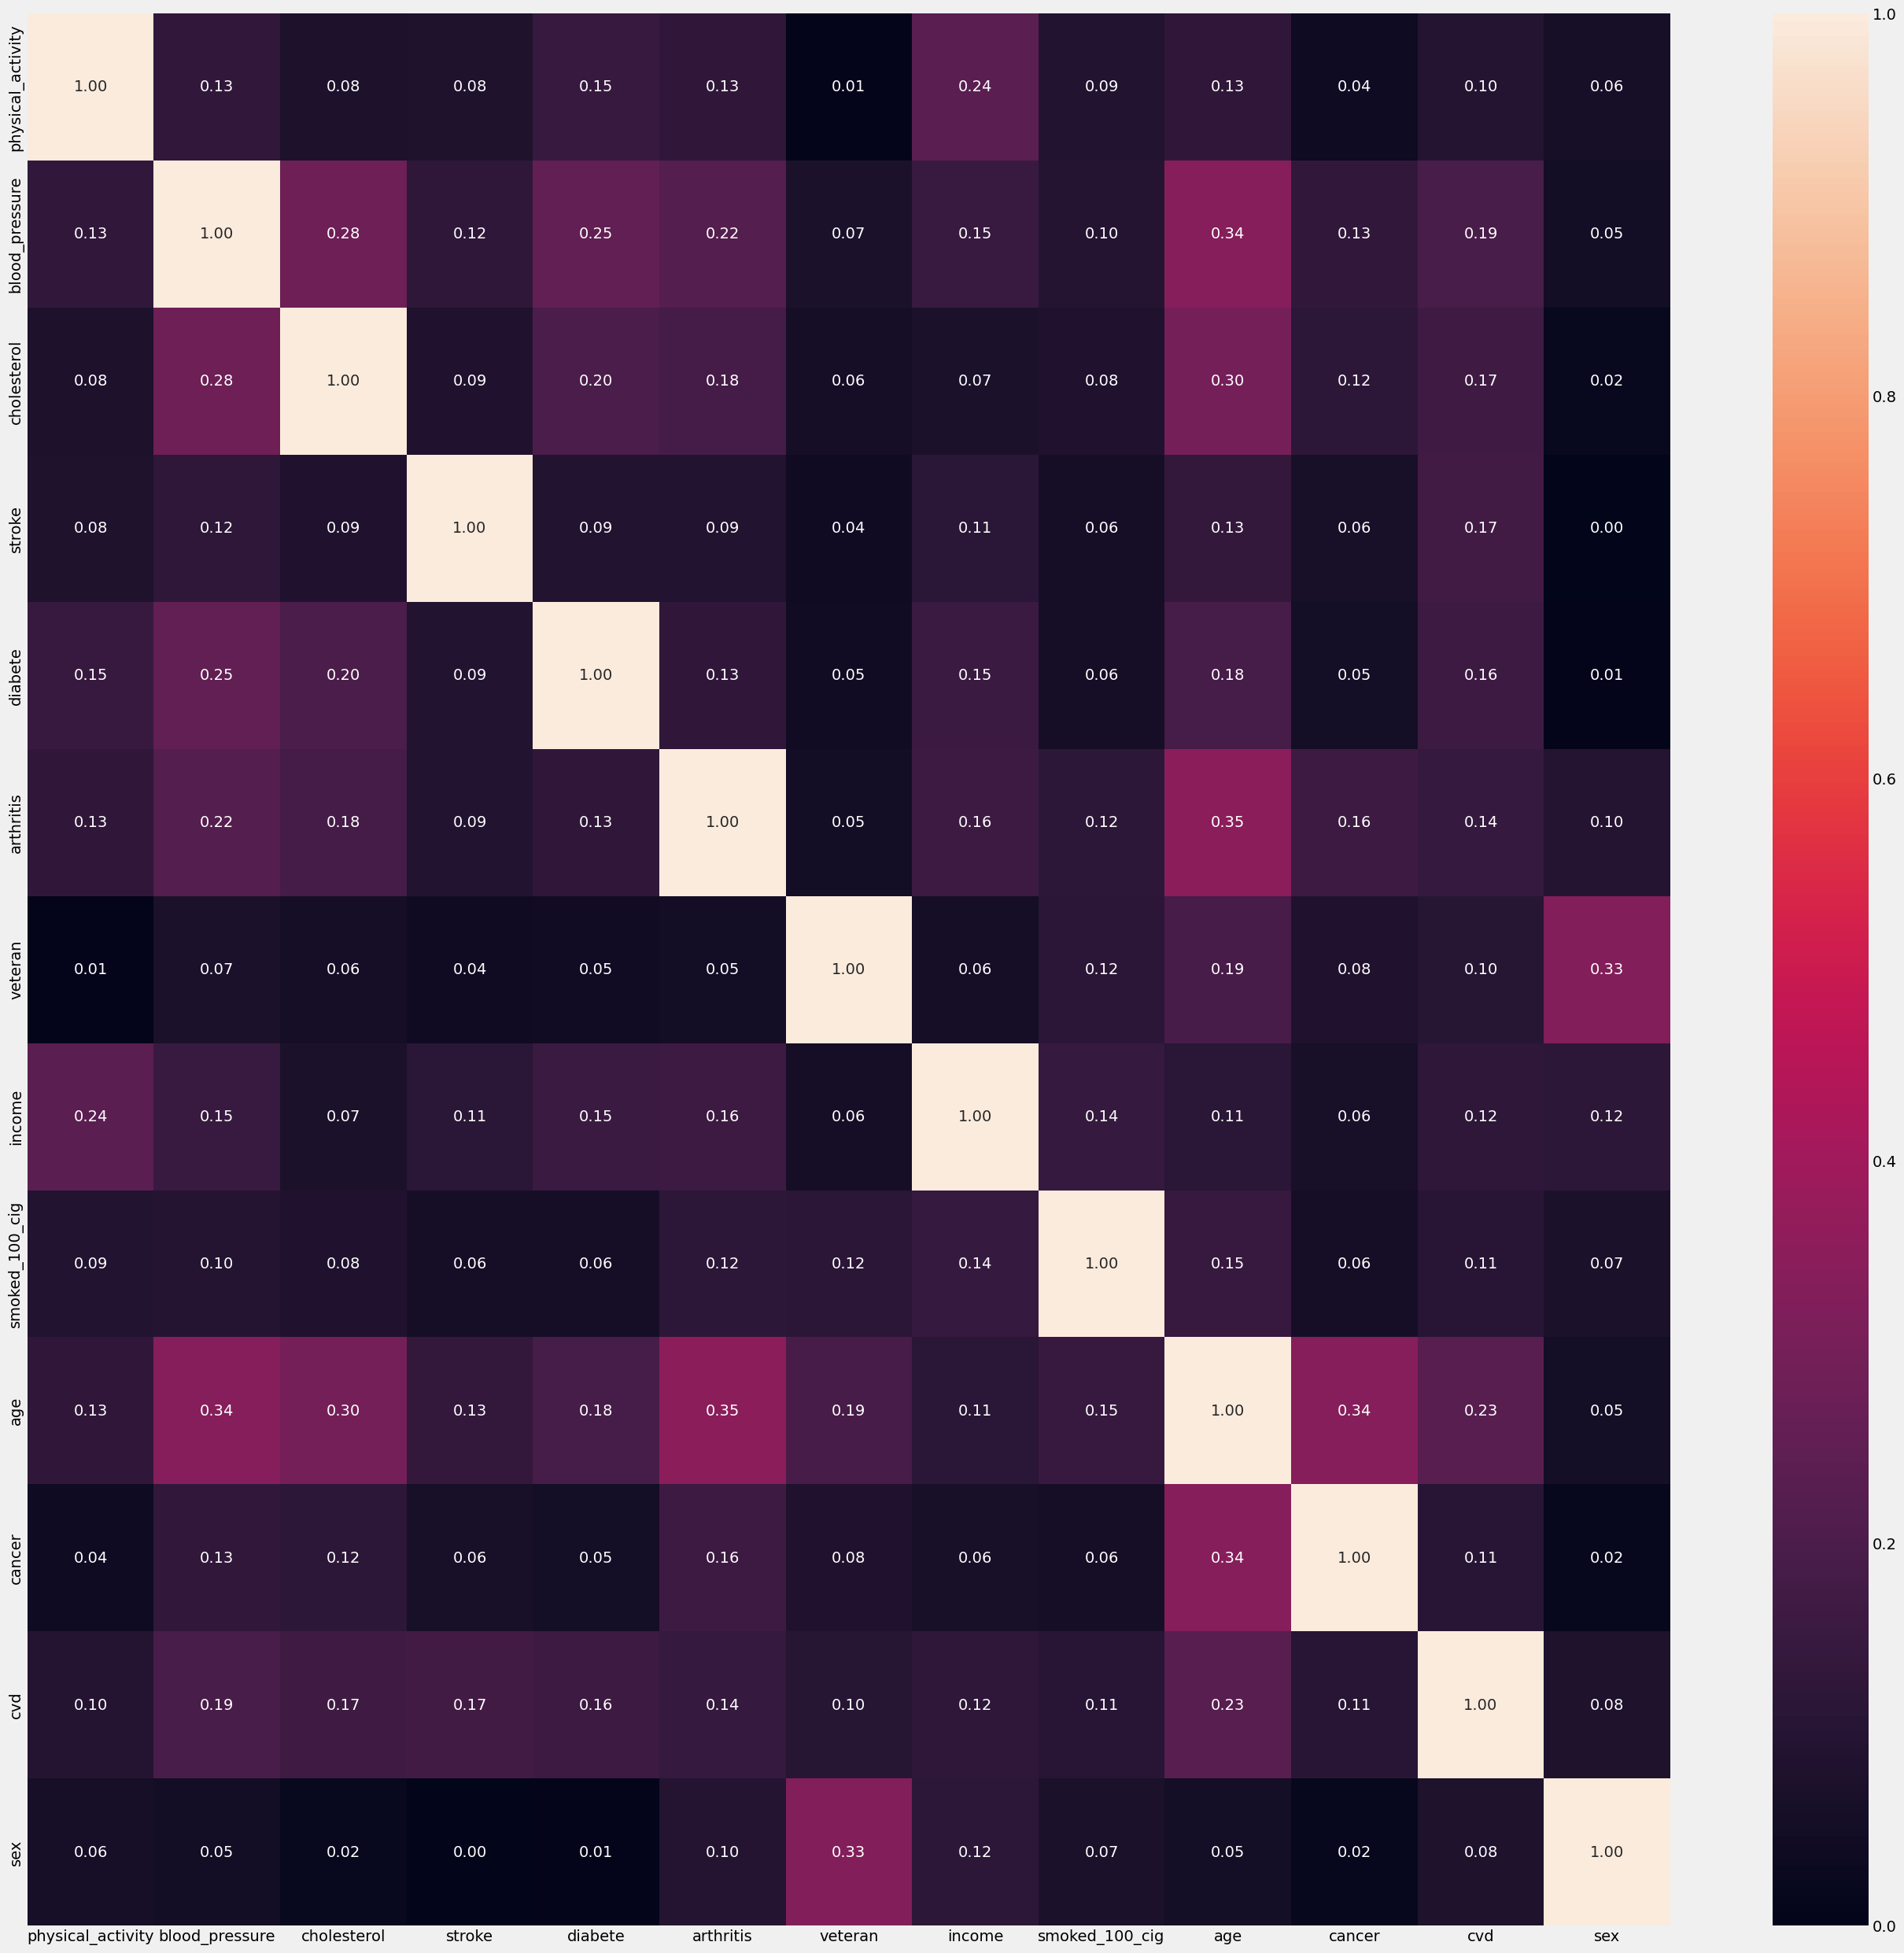

In [11]:
# Correlation on chosen columns

cat_corr2 = get_corr_mat(data2[chosen_cols])
fig, ax = plt.subplots(figsize=(30,30))
# cmap = sns.diverging_palette(180, 180, as_cmap=True)
sns.heatmap(cat_corr2, annot = True, fmt='.2f')#, cmap=cmap)
plt.show()

In [18]:
# Transform the data from categorical to numerical

data1 = data0.copy()
data1.replace({'yes':1, 'no':0}, inplace=True)

data1['income'] = data1['income'].replace({'<10k':1, '10-15k':2, '15-20k':3, '20-25k':4,
                                           '25-35k':5, '35-50k':6, '50-75k':7, '75-100k':8,
                                           '100-150k':9, '150-200k':10, '>200k':11})
data1['age'] = data1['age'].astype('int')

if 'sex' in chosen_cols:
    data1['sex'] = data1['sex'].replace({'M':1, 'F':0})
    
if 'education' in chosen_cols:
    data1['education'] = data1['education'].replace({'kindergarten':1, 'elementary':2,
                                                     'some high-school':3, 'high-school':4,
                                                     'some college':5, 'college':6})

tzip = zip(['white', 'black', 'indian', 'asian', 'hawaiian', 
            'other', 'multiracial', 'hispanic'], [i + 1 for i in range(8)])
if 'race' in chosen_cols:  
    data1['race'] = data1['race'].replace(dict(tzip))

if 'bmi' in chosen_cols:  
    data1['bmi'] = data1['bmi'].replace({'underweight':1, 'normalweight':2,
                                         'overweight':3, 'obese':4})

for col in chosen_cols:
    print(data1[col].value_counts(), '\n')


1    211210
0     61543
Name: physical_activity, dtype: int64 

0    152582
1    120171
Name: blood_pressure, dtype: int64 

0    162530
1    110223
Name: cholesterol, dtype: int64 

0    261907
1     10846
Name: stroke, dtype: int64 

0    224941
1     47812
Name: diabete, dtype: int64 

0    176088
1     96665
Name: arthritis, dtype: int64 

0    237538
1     35215
Name: veteran, dtype: int64 

7     59656
9     42300
5     36802
8     34529
6     34506
10    15018
11    14752
4     12781
3      8919
2      7031
1      6459
Name: income, dtype: int64 

0    161862
1    110891
Name: smoked_100_cig, dtype: int64 

67    32483
62    31258
72    30302
57    26772
52    23580
82    20895
77    20121
47    19154
42    18817
37    16683
32    13569
27     9906
21     9213
Name: age, dtype: int64 

0    221900
1     50853
Name: cancer, dtype: int64 

0    249330
1     23423
Name: cvd, dtype: int64 

0    145512
1    127241
Name: sex, dtype: int64 



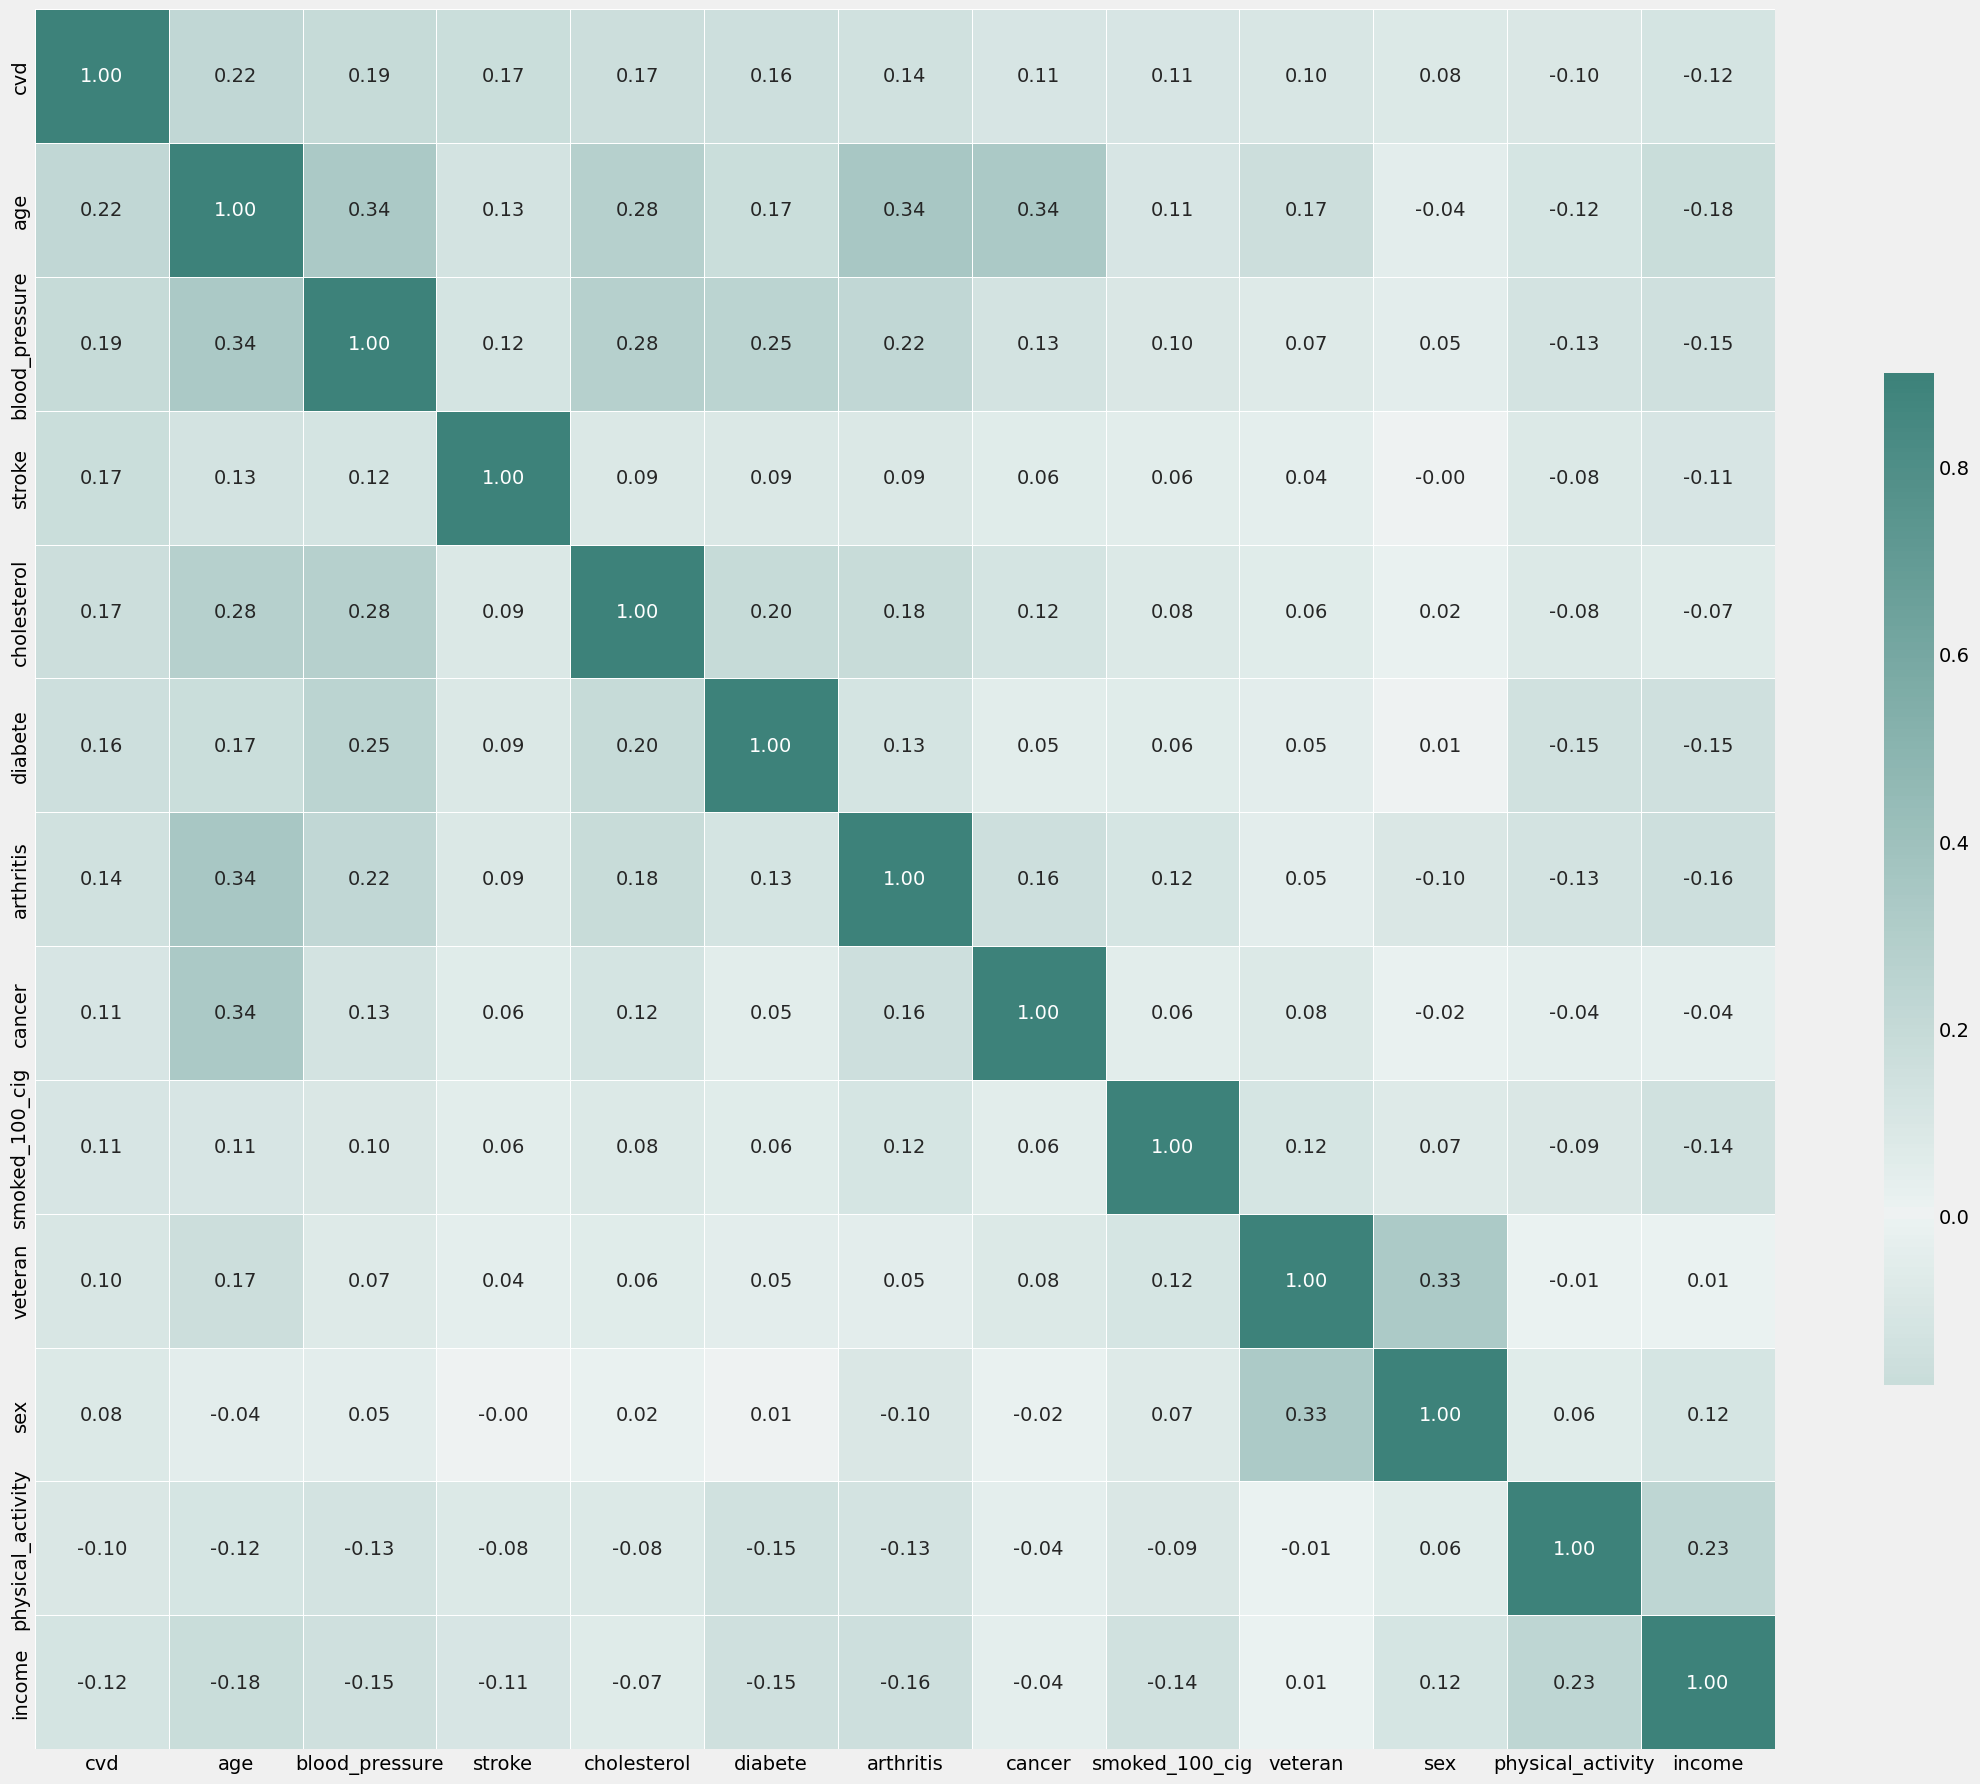

In [19]:
# Correlation (Spearman) after transforming the features to numerical
# -> ~similar coef. as Cramer-V

# corr_matrix_num = data1.corr(method='spearman', numeric_only=False)  
corr_matrix_num = data1[chosen_cols].corr(method='spearman', numeric_only=False)
# display(corr_matrix_num.head())
# corr_matrix = abs(corr_matrix)   # don't care about the sign, only the absolute values
# by sorting by corr with target, when several cols are correlated it is the one the 
# most correlated with the target that will be kept
corr_matrix_num = corr_matrix_num.sort_values(by='cvd', ascending=False)
corr_matrix_num = corr_matrix_num[corr_matrix_num.index]

mask = np.zeros_like(corr_matrix_num, dtype=bool)
mask[np.triu_indices_from(mask)] = True
# Want diagonal elements as well?
# mask[np.diag_indices_from(mask)] = False

f, ax = plt.subplots(figsize=(25, 25))
cmap = sns.diverging_palette(180, 180, as_cmap=True)

sns_plot = sns.heatmap(corr_matrix_num,  cmap=cmap, vmax=.9, center=0, fmt='.2f',  # mask=mask,
                       square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True) 

# fig = sns_plot.get_figure()
# fig.savefig("features_heatmap.png")

In [51]:
for col in chosen_cols:
    data1[chosen_cols] = data1[chosen_cols].astype(int)
data1[chosen_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272753 entries, 0 to 272752
Data columns (total 13 columns):
 #   Column             Non-Null Count   Dtype
---  ------             --------------   -----
 0   physical_activity  272753 non-null  int32
 1   blood_pressure     272753 non-null  int32
 2   cholesterol        272753 non-null  int32
 3   stroke             272753 non-null  int32
 4   diabete            272753 non-null  int32
 5   arthritis          272753 non-null  int32
 6   veteran            272753 non-null  int32
 7   income             272753 non-null  int32
 8   smoked_100_cig     272753 non-null  int32
 9   age                272753 non-null  int32
 10  cancer             272753 non-null  int32
 11  cvd                272753 non-null  int32
 12  sex                272753 non-null  int32
dtypes: int32(13)
memory usage: 13.5 MB


In [68]:
print(data1[chosen_cols].columns)
print(sum(data1['cvd']) / len(data1['cvd']))
print(54551-4685)   49866/4685

Index(['physical_activity', 'blood_pressure', 'cholesterol', 'stroke',
       'diabete', 'arthritis', 'veteran', 'income', 'smoked_100_cig', 'age',
       'cancer', 'cvd', 'sex'],
      dtype='object')
0.0858762323420824
49866


In [79]:
# Split the data

X = data1[chosen_cols].copy()
y = X.pop('cvd')
# To accelerate the hypertuning, find the best parameters on a subset of the data
# by using test_size = 0.8 and use the best parameters with the "full" date
# by using test_size = 0.2. It actually works better than only using 0.2
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  
                                                    random_state=SEED, stratify=y)

# Data imbalanced
print(X_train.shape, y_test.shape)
print(sum(y_train) / len(y_train), sum(y_test) / len(y_test))
print(sum(y_train), sum(y_test))
display(X_train.head())


(218202, 12) (54551,)
0.08587455660351417 0.08588293523491779
18738 4685


,physical_activity,blood_pressure,cholesterol,stroke,diabete,arthritis,veteran,income,smoked_100_cig,age,cancer,sex
203644,1,0,1,0,0,0,0,4,1,62,0,0
131244,1,0,0,0,0,0,0,5,0,21,0,1
236068,1,0,0,0,0,1,0,5,1,42,0,1
27453,1,0,0,0,0,0,0,9,1,42,0,1
47897,1,1,1,0,0,1,0,8,0,67,1,1


In [80]:
# Scaling (no effect on tree-based algorithms)

scaler = StandardScaler().fit(X_train)   # RobustScaler   # StandardScaler   # MinMaxScaler  
X_train_scaled = pd.DataFrame(scaler.transform(X_train),columns=X.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),columns=X.columns)
display(X_train_scaled.head())

y_train = y_train.reset_index(drop=True) 
y_test = y_test.reset_index(drop=True)
display(y_train.head())

with pd.option_context('display.max_rows', None):
    display(X_train_scaled.describe().T)
    

,physical_activity,blood_pressure,cholesterol,stroke,diabete,arthritis,veteran,income,smoked_100_cig,age,cancer,sex
0,0.539606,-0.887445,1.214362,-0.203232,-0.461514,-0.741312,-0.384695,-1.263655,1.209579,0.309438,-0.478578,-0.934256
1,0.539606,-0.887445,-0.823478,-0.203232,-0.461514,-0.741312,-0.384695,-0.825218,-0.826734,-2.168909,-0.478578,1.070371
2,0.539606,-0.887445,-0.823478,-0.203232,-0.461514,1.348960,-0.384695,-0.825218,1.209579,-0.899512,-0.478578,1.070371
3,0.539606,-0.887445,-0.823478,-0.203232,-0.461514,-0.741312,-0.384695,0.928529,1.209579,-0.899512,-0.478578,1.070371
4,0.539606,1.126830,1.214362,-0.203232,-0.461514,1.348960,-0.384695,0.490092,-0.826734,0.611675,2.089523,1.070371


0    0
1    0
2    0
3    0
4    0
Name: cvd, dtype: int32

,count,mean,std,min,25%,50%,75%,max
physical_activity,218202.0,-8.691206e-17,1.000002,-1.853205,0.539606,0.539606,0.539606,0.539606
blood_pressure,218202.0,2.963281e-17,1.000002,-0.887445,-0.887445,-0.887445,1.126830,1.126830
cholesterol,218202.0,-5.021296e-17,1.000002,-0.823478,-0.823478,-0.823478,1.214362,1.214362
stroke,218202.0,-6.864392e-17,1.000002,-0.203232,-0.203232,-0.203232,-0.203232,4.920477
diabete,218202.0,-1.029008e-17,1.000002,-0.461514,-0.461514,-0.461514,-0.461514,2.166783
arthritis,218202.0,4.483998e-17,1.000002,-0.741312,-0.741312,-0.741312,1.348960,1.348960
veteran,218202.0,-2.494366e-17,1.000002,-0.384695,-0.384695,-0.384695,-0.384695,2.599460
income,218202.0,5.874461e-17,1.000002,-2.578966,-0.825218,0.051656,0.928529,1.805403
smoked_100_cig,218202.0,-3.523374e-17,1.000002,-0.826734,-0.826734,-0.826734,1.209579,1.209579
age,218202.0,-7.404947e-17,1.000002,-2.168909,-0.597274,0.007200,0.913913,1.518387



--- Logistic Regression Model ---
Scores on the train set:
   accuracy:  0.725
   AUC:  0.748
   precision:  0.207
   recall:  0.776
   f1:  0.326


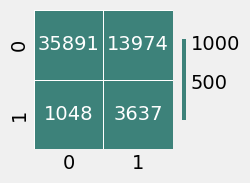

Scores on the test set:
   accuracy:  0.723
   AUC:  0.748
   precision:  0.206
   recall:  0.777
   f1:  0.325


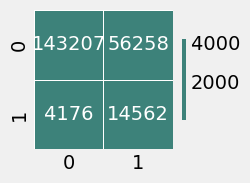


--- XG Boost Model ---
Scores on the train set:
   accuracy:  0.74
   AUC:  0.801
   precision:  0.232
   recall:  0.874
   f1:  0.366


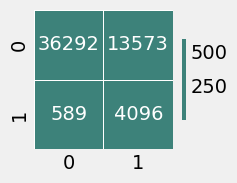

Scores on the test set:
   accuracy:  0.717
   AUC:  0.728
   precision:  0.196
   recall:  0.742
   f1:  0.31


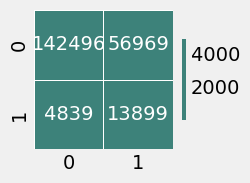


--- Random forest Model ---
Scores on the train set:
   accuracy:  0.904
   AUC:  0.892
   precision:  0.468
   recall:  0.879
   f1:  0.611


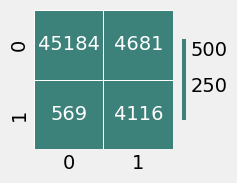

Scores on the test set:
   accuracy:  0.835
   AUC:  0.589
   precision:  0.194
   recall:  0.292
   f1:  0.233


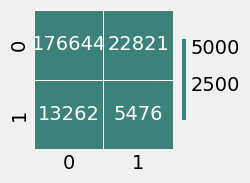


--- Extra Tree Model ---
Scores on the train set:
   accuracy:  0.868
   AUC:  0.911
   precision:  0.392
   recall:  0.963
   f1:  0.557


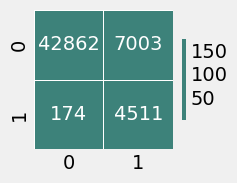

Scores on the test set:
   accuracy:  0.797
   AUC:  0.602
   precision:  0.175
   recall:  0.367
   f1:  0.237


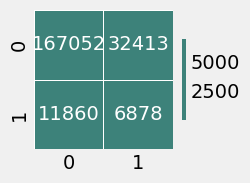

Learning rate set to 0.056826
0:	learn: 0.6734009	total: 238ms	remaining: 3m 57s
1:	learn: 0.6585607	total: 273ms	remaining: 2m 16s
2:	learn: 0.6437221	total: 302ms	remaining: 1m 40s
3:	learn: 0.6299413	total: 329ms	remaining: 1m 21s
4:	learn: 0.6186301	total: 351ms	remaining: 1m 9s
5:	learn: 0.6083532	total: 377ms	remaining: 1m 2s
6:	learn: 0.5987076	total: 406ms	remaining: 57.6s
7:	learn: 0.5901198	total: 430ms	remaining: 53.3s
8:	learn: 0.5825688	total: 457ms	remaining: 50.3s
9:	learn: 0.5762308	total: 485ms	remaining: 48s
10:	learn: 0.5698222	total: 510ms	remaining: 45.9s
11:	learn: 0.5642851	total: 536ms	remaining: 44.1s
12:	learn: 0.5591217	total: 561ms	remaining: 42.6s
13:	learn: 0.5544078	total: 588ms	remaining: 41.4s
14:	learn: 0.5505952	total: 613ms	remaining: 40.2s
15:	learn: 0.5473259	total: 637ms	remaining: 39.2s
16:	learn: 0.5441624	total: 666ms	remaining: 38.5s
17:	learn: 0.5408490	total: 698ms	remaining: 38.1s
18:	learn: 0.5379815	total: 724ms	remaining: 37.4s
19:	learn

166:	learn: 0.4879340	total: 4.72s	remaining: 23.5s
167:	learn: 0.4879190	total: 4.74s	remaining: 23.5s
168:	learn: 0.4878593	total: 4.76s	remaining: 23.4s
169:	learn: 0.4877962	total: 4.79s	remaining: 23.4s
170:	learn: 0.4877051	total: 4.82s	remaining: 23.3s
171:	learn: 0.4876575	total: 4.84s	remaining: 23.3s
172:	learn: 0.4876555	total: 4.86s	remaining: 23.2s
173:	learn: 0.4875909	total: 4.88s	remaining: 23.2s
174:	learn: 0.4875136	total: 4.91s	remaining: 23.1s
175:	learn: 0.4873771	total: 4.94s	remaining: 23.1s
176:	learn: 0.4872144	total: 4.96s	remaining: 23.1s
177:	learn: 0.4871343	total: 4.99s	remaining: 23s
178:	learn: 0.4871342	total: 5s	remaining: 22.9s
179:	learn: 0.4870750	total: 5.02s	remaining: 22.9s
180:	learn: 0.4869680	total: 5.05s	remaining: 22.9s
181:	learn: 0.4868889	total: 5.08s	remaining: 22.8s
182:	learn: 0.4868047	total: 5.1s	remaining: 22.8s
183:	learn: 0.4868018	total: 5.12s	remaining: 22.7s
184:	learn: 0.4866591	total: 5.15s	remaining: 22.7s
185:	learn: 0.4865

332:	learn: 0.4720199	total: 9.14s	remaining: 18.3s
333:	learn: 0.4719567	total: 9.16s	remaining: 18.3s
334:	learn: 0.4718576	total: 9.2s	remaining: 18.3s
335:	learn: 0.4718108	total: 9.22s	remaining: 18.2s
336:	learn: 0.4717195	total: 9.24s	remaining: 18.2s
337:	learn: 0.4716477	total: 9.28s	remaining: 18.2s
338:	learn: 0.4715875	total: 9.3s	remaining: 18.1s
339:	learn: 0.4715264	total: 9.33s	remaining: 18.1s
340:	learn: 0.4714448	total: 9.36s	remaining: 18.1s
341:	learn: 0.4712627	total: 9.39s	remaining: 18.1s
342:	learn: 0.4711624	total: 9.41s	remaining: 18s
343:	learn: 0.4710906	total: 9.44s	remaining: 18s
344:	learn: 0.4710285	total: 9.46s	remaining: 18s
345:	learn: 0.4709447	total: 9.49s	remaining: 17.9s
346:	learn: 0.4708498	total: 9.52s	remaining: 17.9s
347:	learn: 0.4707390	total: 9.55s	remaining: 17.9s
348:	learn: 0.4706553	total: 9.58s	remaining: 17.9s
349:	learn: 0.4705721	total: 9.6s	remaining: 17.8s
350:	learn: 0.4704983	total: 9.63s	remaining: 17.8s
351:	learn: 0.4704420

493:	learn: 0.4614216	total: 13.6s	remaining: 13.9s
494:	learn: 0.4613720	total: 13.6s	remaining: 13.8s
495:	learn: 0.4612964	total: 13.6s	remaining: 13.8s
496:	learn: 0.4612744	total: 13.6s	remaining: 13.8s
497:	learn: 0.4612098	total: 13.7s	remaining: 13.8s
498:	learn: 0.4611395	total: 13.7s	remaining: 13.7s
499:	learn: 0.4610861	total: 13.7s	remaining: 13.7s
500:	learn: 0.4610461	total: 13.7s	remaining: 13.7s
501:	learn: 0.4610108	total: 13.8s	remaining: 13.6s
502:	learn: 0.4609720	total: 13.8s	remaining: 13.6s
503:	learn: 0.4609280	total: 13.8s	remaining: 13.6s
504:	learn: 0.4608659	total: 13.8s	remaining: 13.6s
505:	learn: 0.4608270	total: 13.9s	remaining: 13.5s
506:	learn: 0.4607725	total: 13.9s	remaining: 13.5s
507:	learn: 0.4607334	total: 13.9s	remaining: 13.5s
508:	learn: 0.4606908	total: 13.9s	remaining: 13.5s
509:	learn: 0.4606426	total: 14s	remaining: 13.4s
510:	learn: 0.4605912	total: 14s	remaining: 13.4s
511:	learn: 0.4605560	total: 14s	remaining: 13.4s
512:	learn: 0.4604

653:	learn: 0.4530717	total: 17.9s	remaining: 9.48s
654:	learn: 0.4530413	total: 17.9s	remaining: 9.45s
655:	learn: 0.4529860	total: 18s	remaining: 9.42s
656:	learn: 0.4529495	total: 18s	remaining: 9.39s
657:	learn: 0.4529120	total: 18s	remaining: 9.37s
658:	learn: 0.4528458	total: 18.1s	remaining: 9.34s
659:	learn: 0.4528122	total: 18.1s	remaining: 9.31s
660:	learn: 0.4527679	total: 18.1s	remaining: 9.29s
661:	learn: 0.4527366	total: 18.1s	remaining: 9.26s
662:	learn: 0.4526854	total: 18.2s	remaining: 9.23s
663:	learn: 0.4526371	total: 18.2s	remaining: 9.2s
664:	learn: 0.4525875	total: 18.2s	remaining: 9.18s
665:	learn: 0.4525594	total: 18.2s	remaining: 9.15s
666:	learn: 0.4524975	total: 18.3s	remaining: 9.12s
667:	learn: 0.4524515	total: 18.3s	remaining: 9.09s
668:	learn: 0.4524059	total: 18.3s	remaining: 9.07s
669:	learn: 0.4523496	total: 18.4s	remaining: 9.04s
670:	learn: 0.4523018	total: 18.4s	remaining: 9.01s
671:	learn: 0.4522525	total: 18.4s	remaining: 8.98s
672:	learn: 0.45220

816:	learn: 0.4459074	total: 22.3s	remaining: 5s
817:	learn: 0.4458472	total: 22.3s	remaining: 4.97s
818:	learn: 0.4458074	total: 22.4s	remaining: 4.94s
819:	learn: 0.4457653	total: 22.4s	remaining: 4.92s
820:	learn: 0.4457323	total: 22.4s	remaining: 4.89s
821:	learn: 0.4456993	total: 22.5s	remaining: 4.86s
822:	learn: 0.4456792	total: 22.5s	remaining: 4.83s
823:	learn: 0.4456357	total: 22.5s	remaining: 4.81s
824:	learn: 0.4456011	total: 22.5s	remaining: 4.78s
825:	learn: 0.4455631	total: 22.6s	remaining: 4.75s
826:	learn: 0.4455342	total: 22.6s	remaining: 4.72s
827:	learn: 0.4454691	total: 22.6s	remaining: 4.7s
828:	learn: 0.4454340	total: 22.6s	remaining: 4.67s
829:	learn: 0.4454165	total: 22.7s	remaining: 4.64s
830:	learn: 0.4453711	total: 22.7s	remaining: 4.61s
831:	learn: 0.4453408	total: 22.7s	remaining: 4.59s
832:	learn: 0.4453242	total: 22.7s	remaining: 4.56s
833:	learn: 0.4453001	total: 22.8s	remaining: 4.53s
834:	learn: 0.4452686	total: 22.8s	remaining: 4.5s
835:	learn: 0.445

978:	learn: 0.4400214	total: 26.8s	remaining: 574ms
979:	learn: 0.4400015	total: 26.8s	remaining: 547ms
980:	learn: 0.4399638	total: 26.8s	remaining: 520ms
981:	learn: 0.4398745	total: 26.9s	remaining: 492ms
982:	learn: 0.4398368	total: 26.9s	remaining: 465ms
983:	learn: 0.4398053	total: 26.9s	remaining: 438ms
984:	learn: 0.4397851	total: 26.9s	remaining: 410ms
985:	learn: 0.4397618	total: 27s	remaining: 383ms
986:	learn: 0.4397050	total: 27s	remaining: 356ms
987:	learn: 0.4396718	total: 27s	remaining: 328ms
988:	learn: 0.4396461	total: 27.1s	remaining: 301ms
989:	learn: 0.4395857	total: 27.1s	remaining: 274ms
990:	learn: 0.4395532	total: 27.1s	remaining: 246ms
991:	learn: 0.4395240	total: 27.1s	remaining: 219ms
992:	learn: 0.4394480	total: 27.2s	remaining: 191ms
993:	learn: 0.4393781	total: 27.2s	remaining: 164ms
994:	learn: 0.4393307	total: 27.2s	remaining: 137ms
995:	learn: 0.4393044	total: 27.2s	remaining: 109ms
996:	learn: 0.4392304	total: 27.3s	remaining: 82ms
997:	learn: 0.43921

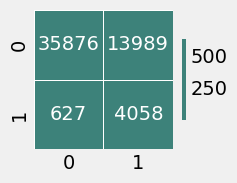

Scores on the test set:
   accuracy:  0.714
   AUC:  0.738
   precision:  0.199
   recall:  0.768
   f1:  0.316


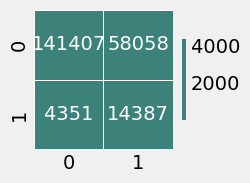

In [56]:
# Models

coef_imbalance = 1 / 0.085876   # nb_negative / nb_positive

model_lr = LogisticRegression(random_state=SEED, n_jobs=-1, max_iter=1000, class_weight="balanced")
model_xgb = XGBClassifier(random_state=SEED, n_jobs=-1, scale_pos_weight=coef_imbalance)
model_rf = RandomForestClassifier(random_state=SEED, n_jobs=-1, class_weight="balanced")
model_xt = ExtraTreesClassifier(random_state=SEED, n_jobs=-1, class_weight="balanced")
model_cat = CatBoostClassifier(random_state=SEED, scale_pos_weight=coef_imbalance)

model_lr = fit_score_model(model_lr, X_train_scaled, y_train, X_test_scaled, y_test, "Logistic Regression")
model_xgb = fit_score_model(model_xgb, X_train_scaled, y_train, X_test_scaled, y_test, "XG Boost")
model_rf = fit_score_model(model_rf, X_train_scaled, y_train, X_test_scaled, y_test, "Random forest")
model_xt = fit_score_model(model_xt, X_train_scaled, y_train, X_test_scaled, y_test, "Extra Tree")
model_cat = fit_score_model(model_cat, X_train_scaled, y_train, X_test_scaled, y_test, "Cat Boost")


0.622 {'colsample_bytree': 0.96, 'learning_rate': 0.0002492740497949975, 'max_depth': 18, 'n_estimators': 385, 'nthread': -1, 'scale_pos_weight': 11.64469700498393, 'subsample': 0.04}


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_colsample_bytree,param_learning_rate,param_max_depth,param_n_estimators,param_nthread,param_scale_pos_weight,param_subsample,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
49,6.401628,0.374443,0.349918,0.007652,0.96,0.000249,18,385,-1,11.644697,0.04,0.640261,0.625895,0.609785,0.619101,0.615520,0.622112,1.047060e-02,1,0.637527,0.640690,0.644872,0.643086,0.643197,0.641874,2.549742e-03
44,4.856967,0.021055,0.396784,0.015931,0.76,0.000587,19,186,-1,11.644697,0.3,0.631860,0.620446,0.604076,0.615090,0.617302,0.617755,8.951093e-03,2,0.659594,0.663048,0.664481,0.662674,0.664181,0.662796,1.737283e-03
19,4.512717,0.065189,0.356169,0.011690,0.77,0.00081,27,188,-1,11.644697,0.22,0.631596,0.621549,0.601980,0.619244,0.614364,0.617747,9.680084e-03,3,0.670597,0.675318,0.680259,0.677797,0.677249,0.676244,3.233578e-03
17,6.517226,0.048803,0.356167,0.006248,0.71,0.000211,19,391,-1,11.644697,0.03,0.628479,0.611189,0.607980,0.607444,0.616424,0.614303,7.774092e-03,4,0.616382,0.620625,0.622742,0.621158,0.621050,0.620392,2.129556e-03
10,6.317273,0.040254,0.412405,0.015929,0.55,0.004124,14,334,-1,11.644697,0.39,0.627270,0.615133,0.595462,0.615915,0.609826,0.612721,1.033369e-02,5,0.647082,0.650410,0.657068,0.652790,0.652835,0.652037,3.277635e-03
40,8.391234,0.072606,0.611041,0.021087,0.59,0.001915,18,380,-1,11.644697,0.43,0.628832,0.613266,0.594799,0.611993,0.607438,0.611265,1.094453e-02,6,0.663219,0.665293,0.670407,0.666488,0.668277,0.666737,2.464308e-03
11,7.766935,0.048804,0.621730,0.006249,0.73,0.001179,24,324,-1,11.644697,0.4,0.622049,0.607997,0.596048,0.604468,0.600862,0.606285,8.819820e-03,7,0.678500,0.679331,0.686198,0.682356,0.682218,0.681721,2.712171e-03
5,4.536638,0.066289,0.284308,0.015305,0.55,0.00045,28,255,-1,11.644697,0.2,0.601836,0.598894,0.594403,0.598927,0.600910,0.598994,2.562794e-03,8,0.602685,0.604035,0.606975,0.605082,0.603829,0.604521,1.443909e-03
34,6.359668,0.090358,0.431149,0.023379,0.7,0.003113,10,320,-1,11.644697,0.23,0.615332,0.595683,0.590581,0.599949,0.591660,0.598641,8.974739e-03,9,0.645815,0.649473,0.655908,0.652892,0.652453,0.651308,3.421195e-03
37,7.105705,0.034263,0.581114,0.026876,0.86,0.000792,21,241,-1,11.644697,0.34,0.610738,0.595812,0.597115,0.600067,0.589221,0.598591,7.034594e-03,10,0.710221,0.711220,0.712511,0.709503,0.713296,0.711350,1.402630e-03


,mean_test_score,std_test_score,best
49,0.622112,1.047060e-02,0.611642
44,0.617755,8.951093e-03,0.608804
19,0.617747,9.680084e-03,0.608067
17,0.614303,7.774092e-03,0.606529
10,0.612721,1.033369e-02,0.602388
40,0.611265,1.094453e-02,0.600321
11,0.606285,8.819820e-03,0.597465
5,0.598994,2.562794e-03,0.596431
14,0.598366,3.229184e-03,0.595137
37,0.598591,7.034594e-03,0.591556



--- Final test Model ---
Scores on the train set:
   accuracy:  0.686
   AUC:  0.764
   precision:  0.196
   recall:  0.858
   f1:  0.32


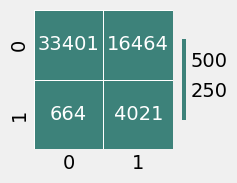

Scores on the test set:
   accuracy:  0.679
   AUC:  0.749
   precision:  0.189
   recall:  0.834
   f1:  0.308


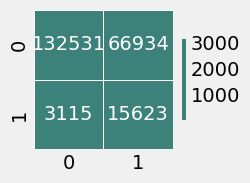

In [77]:
# Hyperparameters tuning for XGBoost

my_f2_scorer = make_scorer(fbeta_score, beta=3)
# by increasing beta FN decreases but FP increases (and F1 decreases)
# imagine a cost associated with FN and FP (and TP and TN)

from scipy.stats import loguniform     

param_distribution = { 
    'n_estimators': range(100, 400, 1),
    'learning_rate': loguniform(1e-4, 1e-1),
    #'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : range(8, 30),
    'subsample': [x / 100 for x in range(1, 51, 1)],
    'colsample_bytree': [x / 100 for x in range(51, 101, 1)],
    'nthread': [-1],
    'scale_pos_weight': [coef_imbalance] 
}

gs_xgb = RandomizedSearchCV(estimator=model_xgb, 
                            param_distributions=param_distribution, 
                            cv=5,    # stratified by default
                            scoring=my_f2_scorer,  # 'f1'
                            n_iter=50, 
                            n_jobs=-1,
                            return_train_score=True,
                            # random_state=SEED  # don't use it if want real randomness!
)
gs_xgb.fit(X_train_scaled, y_train)

print(round(gs_xgb.best_score_, 3), gs_xgb.best_params_)
# print(gs_xgb.cv_results_.keys)
with pd.option_context('display.max_columns', None):
    (display(pd.DataFrame(gs_xgb.cv_results_).sort_values(by='mean_test_score',
                                                          ascending=False)
                                             .drop('params', axis=1)))


df_rank = (pd.DataFrame(gs_xgb.cv_results_).sort_values(by='mean_test_score', 
                                                        ascending=False)
                                           .drop('params', axis=1)
                                           [['mean_test_score',
                                             'std_test_score']])
df_rank['best'] = df_rank['mean_test_score'] - df_rank['std_test_score']
display(df_rank.sort_values(by='best', ascending=False))


params = dict(**gs_xgb.best_params_, **{'random_state':SEED})
# print(params)
model_xgb = XGBClassifier(**params)  #, random_state=SEED)
model_xgb = fit_score_model(model_xgb, X_train_scaled, y_train,
                            X_test_scaled, y_test, "Final test")

# with 20% of the data for train:
# 0.357 {'colsample_bytree': 0.85, 'learning_rate': 0.0034933972905984525, 'max_depth': 19, 'n_estimators': 172, 'nthread': -1, 'scale_pos_weight': 11.64469700498393, 'subsample': 0.04}
# 0.36 {'colsample_bytree': 0.88, 'learning_rate': 0.009497666296036881, 'max_depth': 22, 'max_features': 'sqrt', 'n_estimators': 192, 'nthread': -1, 'scale_pos_weight': 11.64469700498393, 'subsample': 0.07}



--- Final test Model ---
Scores on the train set:
   accuracy:  0.653
   AUC:  0.756
   precision:  0.183
   recall:  0.881
   f1:  0.304


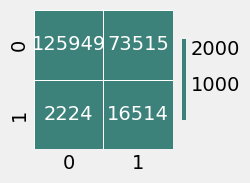

Scores on the test set:
   accuracy:  0.649
   AUC:  0.748
   precision:  0.18
   recall:  0.867
   f1:  0.298


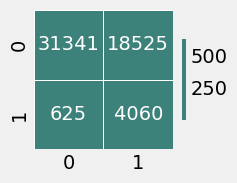

In [81]:
best_par = {'colsample_bytree': 0.96, 'learning_rate': 0.0002492740497949975, 'max_depth': 18, 'n_estimators': 385, 'nthread': -1, 'scale_pos_weight': 11.64469700498393, 'subsample': 0.04}
model_xgb = XGBClassifier(**best_par, random_state=SEED)
model_xgb = fit_score_model(model_xgb, X_train_scaled, y_train,
                            X_test_scaled, y_test, "Final test")


0.608 {'solver': 'sag', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 4.923882631706742}


C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_solver,param_penalty,param_class_weight,param_C,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,2.932023,0.441150,0.010756,5.778123e-03,sag,l2,balanced,4.923883,0.630440,0.608696,0.590018,0.606544,0.602998,0.607739,0.013071,1
12,1.140482,0.278372,0.014759,1.418354e-03,saga,l2,balanced,0.002894,0.627204,0.602179,0.591375,0.609511,0.603615,0.606777,0.011774,2
13,0.191844,0.063217,0.028656,3.007722e-02,newton-cholesky,l2,balanced,0.002894,0.627204,0.602179,0.591326,0.609511,0.603615,0.606767,0.011786,3
11,0.138003,0.012569,0.012414,6.208952e-03,liblinear,l2,balanced,0.024245,0.627517,0.602059,0.590492,0.609889,0.603260,0.606643,0.012162,4
6,1.421544,0.080871,0.012496,6.247856e-03,saga,l1,balanced,0.008377,0.630917,0.602490,0.588970,0.608572,0.601731,0.606536,0.013759,5
25,0.681091,0.035070,0.009373,7.653059e-03,saga,l2,balanced,0.001,0.625891,0.603491,0.588530,0.609082,0.605449,0.606489,0.011965,6
3,0.171836,0.017111,0.012496,6.247878e-03,liblinear,l1,balanced,0.07017,0.627622,0.602690,0.589953,0.609205,0.602724,0.606439,0.012296,7
1,0.743370,0.031528,0.014492,2.258015e-03,saga,l2,balanced,0.024245,0.627046,0.601729,0.590594,0.609256,0.603513,0.606428,0.011953,8
2,0.318678,0.018746,0.012496,6.247855e-03,newton-cg,l2,balanced,0.203092,0.626941,0.601729,0.590643,0.609409,0.602774,0.606299,0.011951,9
24,0.306179,0.012496,0.006248,7.652553e-03,newton-cg,None,balanced,14.251027,0.626941,0.601779,0.590495,0.609358,0.602774,0.606269,0.011984,10


C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



--- Final test Model ---
Scores on the train set:
   accuracy:  0.754
   AUC:  0.742
   precision:  0.219
   recall:  0.727
   f1:  0.337


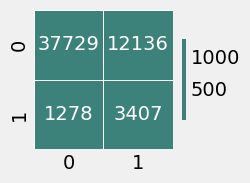

Scores on the test set:
   accuracy:  0.752
   AUC:  0.742
   precision:  0.218
   recall:  0.729
   f1:  0.335


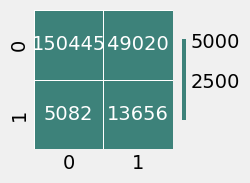

In [78]:
# Hyperparameters tuning for LR

param_distribution = [
  {'penalty': ['l1'], 'solver': ['liblinear', 'saga'], 
   "C": np.logspace(-3, 3, 14), "class_weight": ["balanced"]},  # , None
  {'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs', 'newton-cholesky',
                                 'sag', 'saga', 'liblinear'], 
   "C": np.logspace(-3, 3, 14), "class_weight": ["balanced"]},
  {'penalty': [None], 'solver': ['newton-cg', 'lbfgs',
                                 'newton-cholesky', 'sag', 'saga'], 
   "C": np.logspace(-3, 3, 14), "class_weight": ["balanced"]},  
#   {'penalty': ['elasticnet'], 'solver': ['l1'], 
#      "C": np.logspace(-3, 3, 14), "class_weight": ["balanced", None]},
]

gs_lr = RandomizedSearchCV(estimator=model_lr, 
                            param_distributions=param_distribution, 
                            cv=5,    # stratified by default
                            scoring=my_f2_scorer,  # 'f1' 
                            n_iter=30, 
                            n_jobs=-1,
                            # random_state=SEED
)
gs_lr.fit(X_train_scaled, y_train)

print(round(gs_lr.best_score_, 3), gs_lr.best_params_)
(display(pd.DataFrame(gs_lr.cv_results_).sort_values(by='mean_test_score',
                                                    ascending=False)
                                        .drop('params', axis=1)))

params = dict(**gs_lr.best_params_, **{'random_state':SEED})
# print(params)
model_lr = LogisticRegression(**params)  # random_state=SEED)
model_lr = fit_score_model(model_lr, X_train_scaled, y_train,
                           X_test_scaled, y_test, "Final test")

# 0.326 {'solver': 'lbfgs', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 0.0028942661247167516}


C:\Users\PC\anaconda3\Lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



--- Final test Model ---
Scores on the train set:
   accuracy:  0.725
   AUC:  0.747
   precision:  0.206
   recall:  0.774
   f1:  0.326


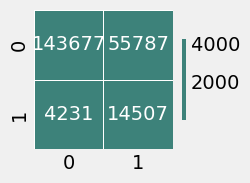

Scores on the test set:
   accuracy:  0.726
   AUC:  0.748
   precision:  0.207
   recall:  0.775
   f1:  0.327


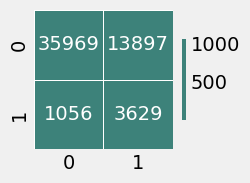

In [82]:
best_par = {'solver': 'sag', 'penalty': 'l2', 'class_weight': 'balanced', 'C': 4.923882631706742}
model_lr = LogisticRegression(**best_par, random_state=SEED)
model_lr = fit_score_model(model_lr, X_train_scaled, y_train,
                            X_test_scaled, y_test, "Final test")

In [ ]:

# Better use Cross-Validation instead of one test set but would make it complicated (as need to do oversampling only on train set inside each fold) 
# Probably best to use pipelines

# To have a better idea, rerun the program 3 times with different seeds and average the 3 f1 scores on the final test set.
#   is it a pb that for each seed, the hyperparameters are not the same?
